## Installing Modules

In [1]:
!pip install spacy==3
!python -m spacy download en_core_web_sm
!pip install pytorch_lightning torchmetrics tableprint

     |████████████████████████████████| 12.7MB 227kB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 624kB 25.4MB/s 
     |████████████████████████████████| 460kB 45.6MB/s 
     |████████████████████████████████| 9.1MB 39.3MB/s 
     |████████████████████████████████| 122kB 54.7MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107107 sha256=905ce55a91760cacead8e1dca78b501aed8044cceeb91bfc741d40ed650e0df5
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: smart-open 5.1.0
    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-5.1.0
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-

## Imports

In [2]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import pandas as pd
import sys, os, pickle
import numpy as np
import math
import matplotlib.pyplot  as plt
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tableprint as tp


# Manual Seed
SEED = 43
torch.manual_seed(SEED)

## Loading Data

Files have been saved to google drive for faster access!

In [3]:
!gdown --id 119bIWhgTxT9wcXCiqj4R-D9rbvkafDR7
!tar -xf /content/Question_Answer_Dataset_v1.2.tar.gz

Downloading...
From: https://drive.google.com/uc?id=119bIWhgTxT9wcXCiqj4R-D9rbvkafDR7
To: /content/Question_Answer_Dataset_v1.2.tar.gz
8.25MB [00:00, 16.1MB/s]


In [4]:
qa08 = pd.read_csv('Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt', sep="\t", engine='python')
print(len(qa08))

1715


In [5]:
qa09 = pd.read_csv('Question_Answer_Dataset_v1.2/S09/question_answer_pairs.txt', sep="\t", engine='python')
print(len(qa09))

825


Unfortunately, the file for 2010 was giving an error, so as suggested on [StackOverflow](https://stackoverflow.com/questions/55010807/pandas-errors-parsererror-expected-after), the ` error_bad_lines=False` argument was used

In [6]:
qa10 = pd.read_csv('Question_Answer_Dataset_v1.2/S10/question_answer_pairs.txt', sep="\t", engine='python', error_bad_lines=False)
print(len(qa10))

1455


Skipping line 765: '	' expected after '"'
Skipping line 876: '	' expected after '"'
Skipping line 1219: '	' expected after '"'


In [7]:
df = pd.concat([qa08, qa09, qa10], axis=0, ignore_index=True)

In [8]:
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


We are only interested in the `Question` and `Answer` columns

In [9]:
df.drop(['ArticleTitle','DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], inplace=True, axis=1)

In [10]:
df.head()

,Question,Answer
0,Was Abraham Lincoln the sixteenth President of...,yes
1,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Did Lincoln sign the National Banking Act of 1...,yes
3,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Did his mother die of pneumonia?,no


Unfortunately, our data has null values that need to be removed

In [11]:
df.isnull().sum()

Question     37
Answer      576
dtype: int64

In [12]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
df.isnull().sum()

Question    0
Answer      0
dtype: int64

## Defining Fields

Now we shall be defining the SRC and TRG fields.

In [15]:
def tokenize_inp(text):
  return [tok.text for tok in nlp.tokenizer(text)][::-1]

def tokenize_out(text):
  return [tok.text for tok in nlp.tokenizer(text)]

In [16]:
SRC= data.Field(sequential = True, tokenize = tokenize_inp, init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)
TRG = data.Field(sequential = True, tokenize = tokenize_out, init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

The `SRC` and `TRG` fields are mapped to the `Question` and `Answer` columns respectively.

In [17]:
fields = [('Question', SRC),('Answer',TRG)]

In [18]:
example = [data.Example.fromlist([df.Question[i],df.Answer[i]], fields) for i in range(df.shape[0])] 

Creat the dataset...

In [19]:
QA = data.Dataset(example, fields)

Split into train and test sets

In [20]:
(train, test) = QA.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [21]:
(len(train), len(test))

(2393, 1026)

An example from the dataset:

In [22]:
vars(train.examples[10])

{'Answer': ['75', 'years'],
 'Question': ['?', 'men', 'for', 'expectancy', 'life', 'the', 'is', 'what']}

In [23]:
" ".join((vars(train.examples[10]))['Question'])

'? men for expectancy life the is what'

## Building Vocabulary

We will build vocabulary  only using the `train` dataset and not the `test` dataset


In [24]:
SRC.build_vocab(train)
TRG.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [25]:
print('Size of input vocab : ', len(SRC.vocab))
print('Size of label vocab : ', len(TRG.vocab))
print('Top 10 words appreared repeatedly :', list(SRC.vocab.freqs.most_common(10)))

Size of input vocab :  3590
Size of label vocab :  2957
Top 10 words appreared repeatedly : [('?', 2356), ('the', 1320), ('of', 780), ('is', 688), ('what', 614), ('in', 542), ('a', 494), ('did', 369), ('was', 367), ('to', 292)]


Initializing GPU as the device

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The Train/Test iterators are initialized here

In [27]:
train_iterator, test_iterator = data.BucketIterator.splits((train, test), batch_size = 32, 
                                                            sort_key = lambda x: len(x.Question),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [28]:
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(SRC.vocab.stoi, tokens)

## Defining Our Model

### Boilerplate code

In [29]:
# Define the model

class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src = batch.Question 
        trg = batch.Answer 
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src = batch.Question 
        trg = batch.Answer 
        output = self(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.running_sanity_check:
            return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
            self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
            self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
            self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [30]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
       
        embedded = self.dropout(self.embedding(src))
        output, (hidden,cell) = self.rnn(embedded)
        
        return hidden,cell

### Decoder

In [31]:
class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout, output_dim):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) 
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
             
        input = input.unsqueeze(0)
             
        embedded = self.dropout(self.embedding(input))
        
        output, (hidden,cell) = self.rnn(embedded, (hidden,cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

### Seq2Seq Model

In [32]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
        self.loss = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

        assert encoder.hid_dim == decoder.hid_dim, "Hidden Dimensions of Encoder and Decoder must be equal"
        assert encoder.n_layers == decoder.n_layers, "Encoder and Decoder must have equal number of layers"
            
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
                
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden,cell = self.decoder(input, hidden, cell)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [33]:
device

device(type='cuda')

In [40]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, OUTPUT_DIM)

model = Seq2Seq(enc, dec, device).to(device)

## Model Checkpoint

This saves the best model (best => model with lowest val loss)

In [41]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [42]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2 Assign 7_2_TL', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_iterator, val_dataloaders=test_iterator)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 4.6 M 
2 | decoder | Decoder          | 6.0 M 
---------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.198    Total estimated model params size (MB)


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      332.43 │      5.8064 │      198.24 │      5.2895 │


│           2 │      167.47 │      5.1208 │      205.08 │      5.3234 │


│           3 │      140.73 │      4.9468 │      212.57 │      5.3593 │


│           4 │      125.51 │      4.8324 │      225.54 │      5.4185 │


│           5 │      116.91 │      4.7614 │      235.11 │      5.4601 │


│           6 │      108.79 │      4.6894 │      248.89 │       5.517 │


│           7 │      97.068 │      4.5754 │      254.31 │      5.5386 │


│           8 │      85.776 │      4.4517 │      259.73 │      5.5597 │


│           9 │      80.453 │      4.3877 │      260.74 │      5.5635 │


│          10 │       71.66 │      4.2719 │      278.31 │      5.6287 │


│          11 │       61.27 │      4.1153 │      286.99 │      5.6594 │


│          12 │       53.81 │      3.9855 │      290.56 │      5.6718 │


│          13 │      47.309 │      3.8567 │      301.51 │      5.7088 │


│          14 │       41.47 │       3.725 │       299.5 │      5.7021 │


│          15 │      34.464 │      3.5399 │      317.75 │      5.7613 │


│          16 │      29.699 │      3.3911 │      335.63 │       5.816 │


│          17 │      25.429 │      3.2359 │       354.8 │      5.8716 │


│          18 │      21.749 │      3.0796 │      352.79 │      5.8659 │


│          19 │      18.595 │      2.9229 │      359.44 │      5.8845 │


│          20 │      15.931 │      2.7683 │      401.65 │      5.9956 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

## Model Training and Evaluation

First define the optimizer and loss functions

In [37]:
root='./csv_logs/' + 'END2 Assign 7_2_TL' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

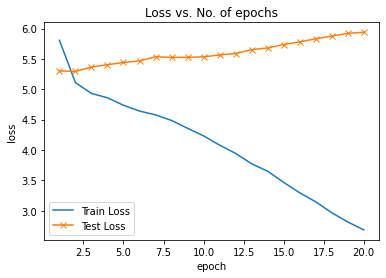

In [38]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

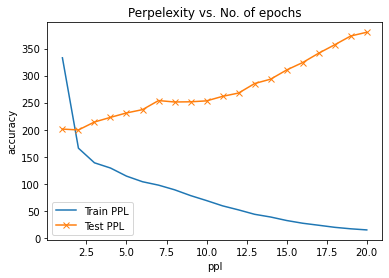

In [39]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('ppl')
plt.ylabel('accuracy')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');